<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [33]</a>'.</span>

In [1]:
import sys
import os
from pathlib import Path

# Handling the scenario where __file__ might not be defined
if '__file__' in globals():
    # If __file__ is defined, use it to get the current directory
    current_dir = Path(os.path.dirname(os.path.abspath(__file__)))
else:
    # If __file__ is not defined, fall back to the current working directory
    current_dir = Path(os.getcwd())

# Calculate the parent directory
parent_dir = current_dir.parent

# Append the parent directory to sys.path
sys.path.append(str(parent_dir))


In [2]:
import geopandas as gpd
import momepy
import networkx as nx
import graph_tool.all as gt
from scripts.nx2gt import nx2gt
import pandas as pd
import matplotlib
import itertools
from shapely.geometry import LineString, point
from shapely.wkt import loads
from tqdm import tqdm
import numpy as np
from dask.distributed import Client, LocalCluster
from dask import delayed
import dask
import math
import concurrent.futures
import matplotlib.pyplot as plt
import osmnx as ox
import scripts.graph_custom as custom_graph_scripts

In [3]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [4]:
# Parameters
local_crs = 27700
place = "Milton_Keynes"
lat = 52.04
lng = -0.76
country = "UK"
crs = 4326
radius = 20


In [5]:
# Parameters
local_crs = 27700
place = "Milton_Keynes"
lat = 52.04
lng = -0.76
country = "UK"
crs = 4326
radius = 20


In [6]:
streets = gpd.read_parquet(f"../output/{place}/streets_p2.pq").to_crs(local_crs).reset_index(drop=True)

In [7]:
streets

,geometry
0,"LINESTRING (462780.438 240826.586, 462737.194 ..."
1,"LINESTRING (462780.438 240826.586, 462339.042 ..."
2,"LINESTRING (463530.206 241125.396, 463394.974 ..."
3,"LINESTRING (462463.393 240651.600, 462464.568 ..."
4,"LINESTRING (462430.448 240682.179, 462435.200 ..."
...,...
52913,"LINESTRING (469499.672 247467.541, 469504.471 ..."
52914,"LINESTRING (490499.324 237371.055, 490490.438 ..."
52915,"LINESTRING (490480.280 237427.494, 490487.650 ..."
52916,"LINESTRING (491270.784 237646.406, 491270.152 ..."


In [8]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

client

/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40915 instead
  warnings.warn(
2024-01-01 17:47:04,734 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 72.00 GiB


2024-01-01 17:47:04,736 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 72.00 GiB


2024-01-01 17:47:04,738 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 72.00 GiB


2024-01-01 17:47:04,739 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 72.00 GiB


2024-01-01 17:47:04,741 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 72.00 GiB


2024-01-01 17:47:04,742 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 72.00 GiB


2024-01-01 17:47:04,745 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 72.00 GiB


2024-01-01 17:47:04,746 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 72.00 GiB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40915/status,
Dashboard: http://127.0.0.1:40915/status,Workers: 8
Total threads: 16,Total memory: 576.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34421,Workers: 8
Dashboard: http://127.0.0.1:40915/status,Total threads: 16
Started: Just now,Total memory: 576.00 GiB
Comm: tcp://127.0.0.1:35453,Total threads: 2
Dashboard: http://127.0.0.1:46541/status,Memory: 72.00 GiB
Nanny: tcp://127.0.0.1:46357,


In [9]:
# Create a pandas dataframe from the multigraph
primal = momepy.gdf_to_nx(streets, approach='primal')

In [10]:
nodes, edges, sw = momepy.nx_to_gdf(primal, points=True, lines=True,
                                    spatial_weights=True)

/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 65 disconnected components.
  warnings.warn(message)


In [11]:
edges = edges.drop_duplicates(subset='geometry')

In [12]:
nodes = nodes.drop_duplicates(subset='geometry')

In [13]:
continuity = momepy.COINS(edges)
stroke_gdf = continuity.stroke_gdf()

In [14]:
stroke_gdf.to_parquet(f"../output/{place}/stroke_gdf.pq")

In [15]:
vertID_dict = {}

In [16]:
counter = itertools.count()

for node in primal.nodes():
    id = next(counter)
    primal.nodes[node]['vertID'] = id
    vertID_dict[id] = node

In [17]:
inverted_vertID_dict = {value: key for key, value in vertID_dict.items()}

# Street Network Shapes

In [18]:
edg_lin = momepy.Linearity(streets)
streets['linearity'] = edg_lin.series

In [19]:
gtG = nx2gt(primal)

## Node Degree

In [20]:

gtG.list_properties()

g = gt.GraphView(gtG)
mm_len = gtG.edge_properties["mm_len"]
vp, ep = gt.betweenness(g, weight = mm_len)

node_degree = {g.vertex_index[v]: v.in_degree() + v.out_degree() for v in g.vertices()}
# convert ID_dict to a DataFrame and rename the index and column
node_degree = pd.DataFrame.from_dict(node_degree, orient='index').rename(columns={0: "node_degree"})
# merge vertID_df and vertices on vertID and node, respectively

approach       (graph)   (type: string, val: primal)
id             (vertex)  (type: string)
nodeID         (vertex)  (type: double)
vertID         (vertex)  (type: double)
geometry       (edge)    (type: string)
mm_len         (edge)    (type: double)


In [21]:
nodes["node_degree"] = node_degree["node_degree"]

In [22]:
# # cross-testing to Momepy implementation

# degree = dict(nx.degree(primal))
# nx.set_node_attributes(primal, degree, 'degree')

# graph = momepy.node_degree(primal, name='degree')

# nodes, edges, sw = momepy.nx_to_gdf(graph, points=True, lines=True,
#                                     spatial_weights=True)

# f, ax = plt.subplots(figsize=(10, 10))

# # Plot edges with a lower zorder
# edges.plot(ax=ax, color='lightgrey', zorder=1)

# # Plot nodes with a higher zorder
# nodes.plot(ax=ax, column='degree', cmap='RdYlBu', markersize=3, zorder=2)

# # Plot nodes
# scatter = ax.scatter(nodes.geometry.x, nodes.geometry.y, c=nodes['degree'], cmap='RdYlBu', s=3, zorder=2)

# # Create a legend
# legend1 = ax.legend(*scatter.legend_elements(num=5),
#                     loc="upper right", title="Node Degree")
# ax.add_artist(legend1)

# ax.set_axis_off()
# plt.show()

# node_degree["node_degree"]
# node_degree_aligned = node_degree["node_degree"].reset_index(drop=True)
# nodes_aligned = nodes["degree"].reset_index(drop=True)

# # Check if all elements are equal
# if not (node_degree_aligned == nodes_aligned).all():
#     raise ValueError("All elements in node_degree_aligned and nodes_aligned are identical.")

# Meshedness + clustering

Eucledean Dist

In [23]:
## validation to networkx
graph = momepy.gdf_to_nx(streets)

graph = momepy.clustering(graph, name='clustering')

graph = momepy.meshedness(graph, radius=500, name='meshedness_eucl_500', distance='mm_len')

graph = momepy.nx_to_gdf(graph, points=True, lines=False, spatial_weights=False)

  0%|          | 0/45685 [00:00<?, ?it/s]

In [24]:
nodes["meshedness_eucl_500"] = graph["meshedness_eucl_500"]
nodes["clustering"] = graph["clustering"]

/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 15 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


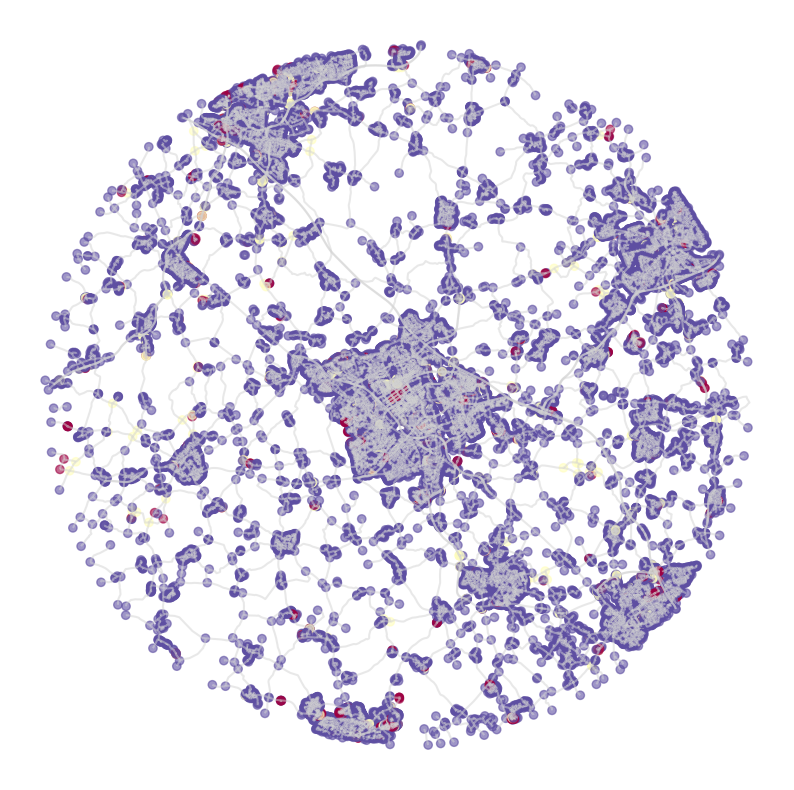

In [25]:
f, ax = plt.subplots(figsize=(10, 10))
# Plot nodes with a higher zorder
nodes.plot(ax=ax, column='clustering', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
streets.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
plt.show()

Topological Distance

In [26]:
## validation to networkx
graph = momepy.gdf_to_nx(streets)

graph = momepy.meshedness(graph, radius=5, name='meshedness_topo_5')

graph = momepy.nx_to_gdf(graph, points=True, lines=False, spatial_weights=False)

  0%|          | 0/45685 [00:00<?, ?it/s]

In [27]:
nodes["meshedness_topo_5"] = graph["meshedness_topo_5"]

/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 15 classes. Setting k to 12.
  self.bins = quantile(y, k=k)


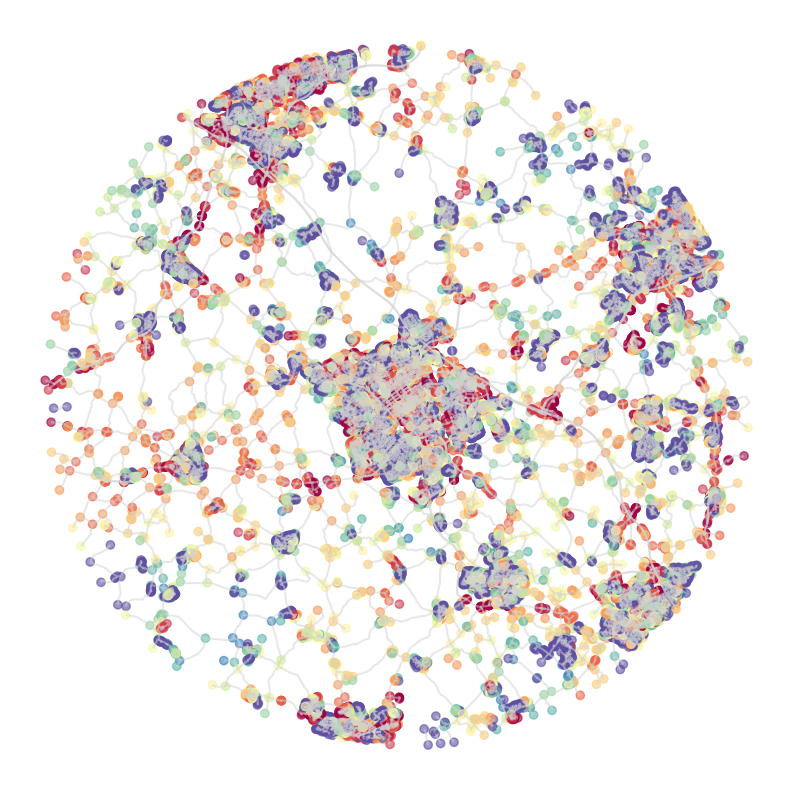

In [28]:
f, ax = plt.subplots(figsize=(10, 10))
# Plot nodes with a higher zorder
nodes.plot(ax=ax, column="meshedness_topo_5", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
streets.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
plt.show()


# Multiple Centrality Analysis

## Closeness Centrality

### Closeness centrality

Closeness centrality could be simplified as the average distance to every other node from each node. As such, it can be measured on the whole network (Global Closeness Centrality) or within a certain limit only (Local Closeness Centrality). 

#### Local closeness
To measure local `closeness_centrality` we need to specify a radius (how far we should go from each node). We can use topological distance (e.g. 5 steps, then radius=5) or metric distance (e.g. 400 metres) - then radius=400 and distance=length of each segment saved as a parameter of each edge. By default, momepy saves length as `mm_len`. 

The weight parameter is used for centrality calculation. Again, we can use metric weight (using the same attribute as above) or no weight (weight=None) at all. Or any other attribute we wish.

In [29]:
local_closeness_clustering = momepy.closeness_centrality(primal, radius=400, name='closeness400', distance='mm_len', weight='mm_len')

  0%|          | 0/45685 [00:00<?, ?it/s]

In [30]:
local_closeness_clustering = momepy.nx_to_gdf(local_closeness_clustering)
local_closeness_clustering = local_closeness_clustering[0]

In [31]:
nodes["closeness_clustering_400m"] = local_closeness_clustering["closeness400"]

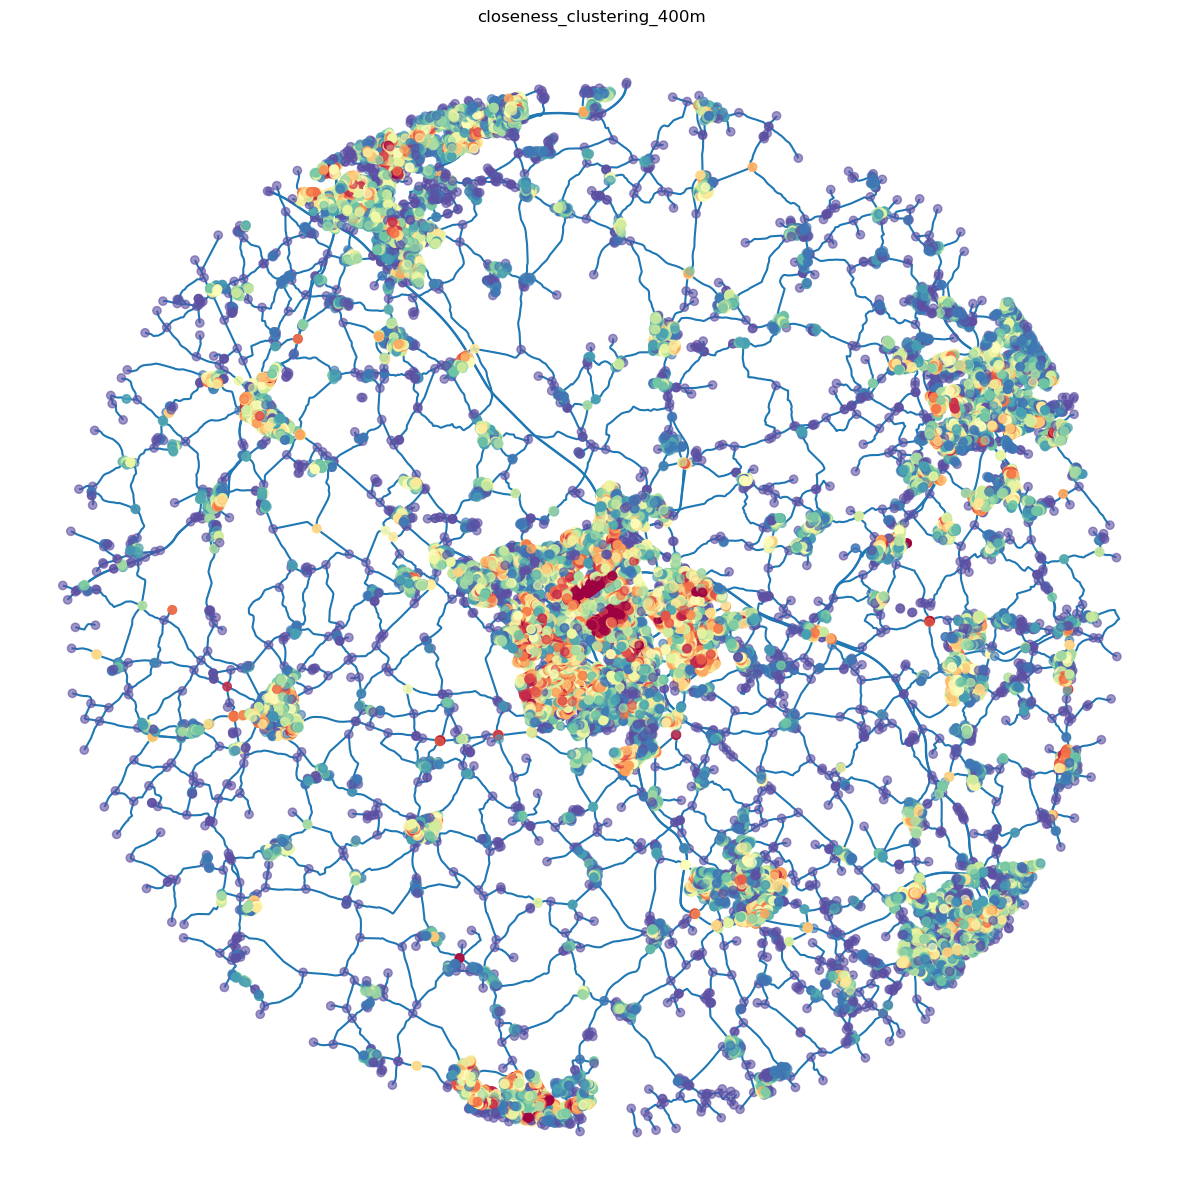

In [32]:

f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column="closeness_clustering_400m", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, zorder=1)
edges.plot(ax=ax, zorder=0)
closeness400 = nodes["closeness_clustering_400m"]

ax.set_axis_off()
ax.set_title("closeness_clustering_400m")
plt.show()

#### Global closeness

Global closeness centrality is a bit simpler as we do not have to specify radius and distance, the rest remains the same.

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [33]:
primal_gdf = momepy.nx_to_gdf(primal, points=False)

unique_ids = edges[~edges['id'].isin(primal_gdf['id'])]
unique_ids

# Convert unique_ids to a list of IDs if it's still a DataFrame
unique_id_list = unique_ids['id'].tolist()

# Drop entries in edges where ID is in unique_id_list
edges = edges[~edges['id'].isin(unique_id_list)]

KeyError: 'id'

In [ ]:
gtG = nx2gt(primal)

g = gt.GraphView(gtG)
mm_len = gtG.edge_properties["mm_len"]
vp = gt.closeness(g, weight = mm_len)

vertex_val = vp.get_array()

nodes['global_closeness_centrality_primal']= vertex_val

nodes

### Betweenness

Betweenness centrality measures the importance of each node or edge for travelling along the network. It measures how many times each node/edge used if we walk using the shortest paths from each node to every other. 

We have two options of how to measure betweenness on primal graphs - on nodes or on edges.

#### Node-based
Node-based betweenness, as the name suggests, measures the betweenness of each node - how many times we would walk through the node.

In [ ]:
g = gt.GraphView(gtG)
mm_len = gtG.edge_properties["mm_len"]
vp, ep = gt.betweenness(g, weight = mm_len)

vertex_val = vp.get_array()

nodes['global_betweeness_centrality_vertex']= vertex_val

In [ ]:
nodes

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='global_betweeness_centrality_vertex', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, zorder=1)
edges.plot(ax=ax, zorder=0)

ax.set_axis_off()
ax.set_title(label='global_betweeness_centrality_vertex')
plt.show()

#### Edge-based

Edge-based betweenness does the same but for edges: how many times we go through each edge (street).

In [ ]:
edge_val = ep.get_array()

edges['betweeness_centrality_edge'] = edge_val

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
edges.plot(ax=ax, column='betweeness_centrality_edge', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, zorder=1)

ax.set_axis_off()
ax.set_title(label='betweeness_centrality_edge')
plt.show()

### Straightness

While both closeness and betweenness are generally used in many applications of network analysis, straightness centrality is specific to street networks as it requires a geographical element. It is measured as a ratio between real and Euclidean distance while waking from each node to every other.

In [ ]:
primal = momepy.straightness_centrality(primal)
gdf = momepy.nx_to_gdf(primal, lines=False)

In [ ]:
nodes["global_straightness_centrality"] = gdf["straightness"]

In [ ]:


nodes["straightness_400m"] = gdf["straightness"]

f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column="straightness_400m", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)

ax.set_axis_off()
ax.set_title("global_straightness_centrality")
plt.show()

### Node values averaged onto edges

In some cases, it is easier to understand centrality results if they are attached to street segments, rather than intersections. We can do an approximation using the mean value attached to start and end node of each edge.

In [ ]:
nodes

In [ ]:
for node in primal.nodes:
    row = nodes[nodes["nodeID"] == primal.nodes[node]["nodeID"]].iloc[0]
    
    columns = row.keys().drop(['nodeID', 'geometry'])
    for column in columns:
        primal.nodes[node][column] = row[column]

In [ ]:
primal.nodes

In [ ]:
momepy.mean_nodes(primal, 'global_straightness_centrality')
momepy.mean_nodes(primal, 'closeness_clustering_400m')
momepy.mean_nodes(primal, 'global_closeness_centrality_primal')
momepy.mean_nodes(primal, 'global_betweeness_centrality_vertex')

In [ ]:
primal_gdf = momepy.nx_to_gdf(primal, points=False)

f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='global_straightness_centrality', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('straightness')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='closeness_clustering_400m', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness400 node based mean')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='global_closeness_centrality_primal', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness global node based mean')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='global_betweeness_centrality_vertex', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweennes node based mean')
plt.show()

In [ ]:
edges["global_straightness_centrality"] = primal_gdf["global_straightness_centrality"]
edges["closeness_clustering_400m"] = primal_gdf["closeness_clustering_400m"]
edges["global_closeness_centrality_primal	"] = primal_gdf["global_closeness_centrality_primal"]
edges["global_betweeness_centrality_vertex"] = primal_gdf["global_betweeness_centrality_vertex"]

In [ ]:
edges

Once we have finished our network analysis on the primal graph, we can save both nodes and edges back to GeoDataFrames.

### Topological vs metric distances

Centrality can be measured topologically (ignoring physical lengths of street segments) or metrically. Moreover, in the case of local centrality, local subgraphs can be also defined topologically and metrically. In the end, you have four options of how to measure centralilty, illustrated on `betweenness_centrality`:

```py
# topologically defined subgraph (5 steps) and topologically measured shortest path
betweenness_centrality(graph, radius=5, distance=None, weight=None)

# topologically defined subgraph (5 steps) and metrically measured shortest path
betweenness_centrality(graph, radius=5, distance=None, weight='edge_length')

# metrically defined subgraph (800 meters) and topologically measured shortest path
betweenness_centrality(graph, radius=800, distance='edge_length', weight=None)

# metrically defined subgraph (800 meters) and metrically measured shortest path
betweenness_centrality(graph, radius=800, distance='edge_length', weight='edge_length')
```

## Dual graph

Dual graph is a bit more complicated concept as it represents street segments as nodes with intersections as edges connecting nodes. The geographical distance is lost as edges are of virtually no length, but we can capture the angle between connected streets. Momepy does that by default, using angles between lines connecting the start and end points of each segment. Hence, we can measure angular centrality.

**Note**: Dual graphs have naturally much more connections than primal ones, so computation of centrality on dual graph takes longer.

In [ ]:
edges["id"] = edges.index

In [ ]:
dual = momepy.gdf_to_nx(edges, approach='dual')

In [ ]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)
dual_gdf

In [ ]:
unique_ids = edges[~edges['id'].isin(dual_gdf['id'])]
unique_ids

# Convert unique_ids to a list of IDs if it's still a DataFrame
unique_id_list = unique_ids['id'].tolist()

# Drop entries in edges where ID is in unique_id_list
edges = edges[~edges['id'].isin(unique_id_list)]

### Angular closeness

The situation with closeness is similar to the one done on primal graphs. We can again do global and local closeness.

#### Local
The difference is that we do not have geographic distance, so we can limit closeness topologically or by another attribute (line angle). The example below uses a topological distance of 5 steps.

In [ ]:
closeness_dual = momepy.closeness_centrality(dual, radius=5, name='angular_closeness_order_5', weight='angle')

dual_gdf = momepy.nx_to_gdf(closeness_dual, points=False)


In [ ]:
edges['angular_closeness_order_5'] = dual_gdf['angular_closeness_order_5']

f, ax = plt.subplots(figsize=(15, 15))
dual_gdf.plot(ax=ax, column='angular_closeness_order_5', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness angular 5')
plt.show()

#### Global

Global angular closeness is then straightforward.

In [ ]:
gtG = nx2gt(dual)

In [ ]:
gtG

In [ ]:
g = gt.GraphView(gtG)
angle = gtG.edge_properties["angle"]
vp = gt.closeness(g, weight = angle)

vertex_val = vp.get_array()


In [ ]:
edges['global_angular_closeness'] = vertex_val

In [ ]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)
f, ax = plt.subplots(figsize=(15, 15))
edges.plot(ax=ax, column='global_angular_closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('global_angular_closeness')
plt.show()

### Angular betweenness
The last option momepy offers is angular betweenness. Just keep in mind, that nodes and edges are not representing the same concepts and it does not make much sense to measure angular betweenness on edges. Moreover, `nx_to_gdf` converts a dual graph to a LineString gdf only.

In [ ]:
angle = gtG.edge_properties["angle"]
ep, vp = gt.betweenness(g, weight = angle)

edges_val = ep.get_array()

In [ ]:
edges["global_angular_betweeness"] = edges_val

In [ ]:
df, ax = plt.subplots(figsize=(15, 15))
edges.plot(ax=ax, column="global_angular_betweeness", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweenness angular')
plt.show()

In [ ]:
edges.to_parquet(f"../output/{place}/edges_p4.pq")
nodes.to_parquet(f"../output/{place}/nodes_p4.pq")